<center><h1>Gunadi_Eben_HW5</h1></center>
<br>
<br>

Name: Eben Gunadi
<br>
Github Username: egunadi
<br>
USC ID: 3976793880

## 1. Decision Trees as Interpretable Models

Import packages

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import _tree
from graphviz import Source
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### (a) Obtain Data

Get the Accute Inamations Data Set

In [46]:
diagnosis_filepath = '../data/diagnosis.data.csv'

diagnosis_headers = ['Temperature', 
                     'Nausea', 
                     'LumbarPain', 
                     'UrinePushing', 
                     'MicturitionPains', 
                     'UrethraBurning', 'UrinaryBladderInflammation', 'RenalPelvisNephritis']

diagnosis_df = pd.read_csv(diagnosis_filepath, delimiter='\t', encoding='utf-8', names=diagnosis_headers)

In [47]:
diagnosis_df['Temperature'] = diagnosis_df['Temperature'].str.replace(',', '.').astype(float)

In [48]:
diagnosis_df['Nausea'] = diagnosis_df['Nausea'].map({'yes': True, 'no': False})
diagnosis_df['LumbarPain'] = diagnosis_df['LumbarPain'].map({'yes': True, 'no': False})
diagnosis_df['UrinePushing'] = diagnosis_df['UrinePushing'].map({'yes': True, 'no': False})
diagnosis_df['MicturitionPains'] = diagnosis_df['MicturitionPains'].map({'yes': True, 'no': False})
diagnosis_df['UrethraBurning'] = diagnosis_df['UrethraBurning'].map({'yes': True, 'no': False})
diagnosis_df['UrinaryBladderInflammation'] = diagnosis_df['UrinaryBladderInflammation'].map({'yes': True, 'no': False})
diagnosis_df['RenalPelvisNephritis'] = diagnosis_df['RenalPelvisNephritis'].map({'yes': True, 'no': False})

In [49]:
diagnosis_df.head()

,Temperature,Nausea,LumbarPain,UrinePushing,MicturitionPains,UrethraBurning,UrinaryBladderInflammation,RenalPelvisNephritis
0,35.5,False,True,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False
2,35.9,False,True,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False
4,36.0,False,True,False,False,False,False,False


In [50]:
diagnosis_df.shape

(120, 8)

### (b) Build a decision tree

In [51]:
# Build a decision tree on the whole data set and plot it. 

X_diagnosis = diagnosis_df.drop(columns=['UrinaryBladderInflammation', 'RenalPelvisNephritis'])
y_diagnosis = diagnosis_df[['UrinaryBladderInflammation', 'RenalPelvisNephritis']]

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_diagnosis, y_diagnosis)

DecisionTreeClassifier(random_state=42)

In [52]:
export_graphviz(
    tree_clf,
    out_file="diagnosis_tree.dot",
    feature_names=X_diagnosis.columns,
    class_names=y_diagnosis.columns,
    rounded=True,
    filled=True
)

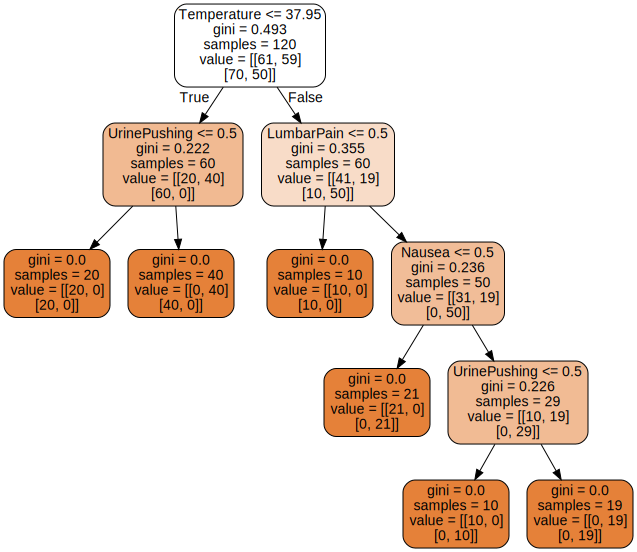

In [53]:
Source.from_file("diagnosis_tree.dot")

### (c) Convert the decision rules

In [54]:
# Convert the decision rules into a set of IF-THEN rules

def tree_to_code(tree, feature_names):
	"""
	Outputs a decision tree model as a Python function
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as a function
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

In [55]:
tree_to_code(tree_clf, list(X_diagnosis.columns))

def tree(Temperature, Nausea, LumbarPain, UrinePushing, MicturitionPains, UrethraBurning):
  if Temperature <= 37.95000076293945:
    if UrinePushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if UrinePushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if Temperature > 37.95000076293945
    if LumbarPain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if LumbarPain > 0.5
      if Nausea <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Nausea > 0.5
        if UrinePushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if UrinePushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### (d) Cost complexity pruning

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

path = tree_clf.cost_complexity_pruning_path(X_diagnosis, y_diagnosis)
alphas = path['ccp_alphas']

accuracy_train = []
accuracy_test = []
for alpha in alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)

    pruned_tree.fit(X_train, y_train)
    y_train_pred = pruned_tree.predict(X_train)
    y_test_pred = pruned_tree.predict(X_test)

    accuracy_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_test.append(accuracy_score(y_test, y_test_pred))

/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

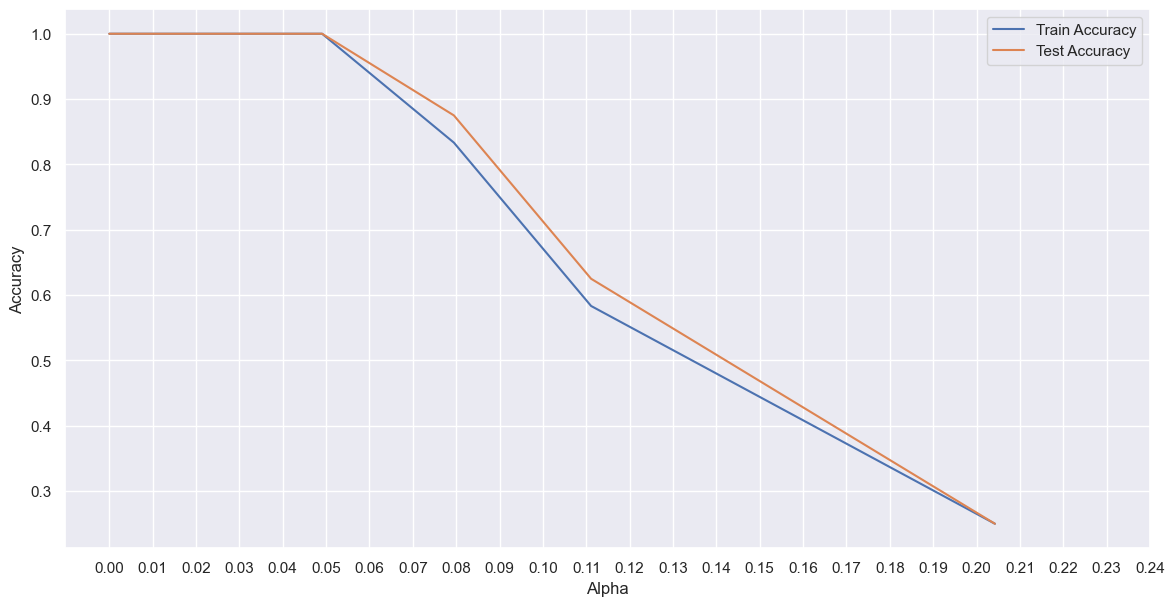

In [113]:
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train, x=alphas, label='Train Accuracy')
sns.lineplot(y=accuracy_test, x=alphas, label='Test Accuracy')
plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

From the above plot, alpha <= 0.05 gives the best accuracy. Will select 0.05 since bigger alphas lead to more interpretable models.

In [106]:
best_tree_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.05)
best_tree_clf.fit(X_diagnosis, y_diagnosis)

DecisionTreeClassifier(ccp_alpha=0.05, random_state=42)

In [107]:
export_graphviz(
    best_tree_clf,
    out_file="best_diagnosis_tree.dot",
    feature_names=X_diagnosis.columns,
    class_names=y_diagnosis.columns,
    rounded=True,
    filled=True
)

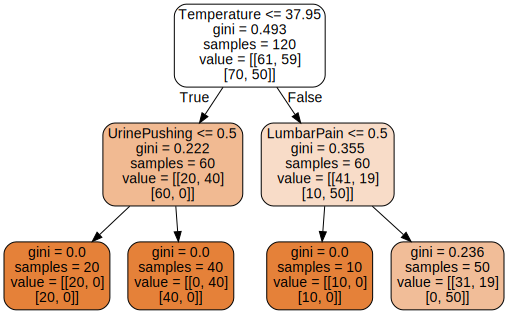

In [108]:
Source.from_file("best_diagnosis_tree.dot")

In [109]:
tree_to_code(best_tree_clf, list(X_diagnosis.columns))

def tree(Temperature, Nausea, LumbarPain, UrinePushing, MicturitionPains, UrethraBurning):
  if Temperature <= 37.95000076293945:
    if UrinePushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if UrinePushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if Temperature > 37.95000076293945
    if LumbarPain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if LumbarPain > 0.5
      return [[31. 19.]
 [ 0. 50.]]


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

### (b) Missing values

### (c) Plot a correlation matrix

### (d) Calculate the Coefficient of Variation CV

### (e) Scatter plots and box plots for highest CV features

### (f) Fit a linear model

### (g) Fit a ridge regression model

### (h) Fit a LASSO model

### (i) Fit a PCR model

### (j) Fit a boosting tree

## References and Citations

- https://stackoverflow.com/questions/45914589/how-to-install-scikit-multilearn-using-conda
- https://stackoverflow.com/questions/52566756/no-module-named-graphviz-in-jupyter-notebook
- https://powerunit-ju.com/wp-content/uploads/2021/04/Aurelien-Geron-Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-Tensorflow_-Concepts-Tools-and-Techniques-to-Build-Intelligent-Systems-OReilly-Media-2019.pdf (Chapter 6)
- https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
- https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/